In [1]:
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
# 1. CONFIGURATION
DATA_DIR = r'C:\Users\ADMIN\Pictures\Machine Learning in Medicine\Practice_3\Infection Segmentation Data'
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 6
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# 2. DATASET LOADER
class InfectionDataset(Dataset):
    def __init__(self, root_dir, phase='Train'):
        self.images = []
        self.lung_masks = []
        self.infect_masks = []
        search_pattern = os.path.join(root_dir, phase, '**', 'images', '*')
        all_img_paths = glob.glob(search_pattern, recursive=True)
        for img_path in all_img_paths:
            if not img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                continue
            parent_dir = os.path.dirname(img_path)       
            grandparent_dir = os.path.dirname(parent_dir) 
            filename = os.path.basename(img_path)
            l_mask_path = os.path.join(grandparent_dir, 'lung masks', filename)
            i_mask_path = os.path.join(grandparent_dir, 'infection masks', filename)
            if os.path.exists(l_mask_path):
                self.images.append(img_path)
                self.lung_masks.append(l_mask_path)
                if os.path.exists(i_mask_path):
                    self.infect_masks.append(i_mask_path)
                else:
                    self.infect_masks.append(None)
        print(f"[{phase}] Loaded: {len(self.images)} images.")
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = cv2.imread(self.images[idx], cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=0)
        l_mask = cv2.imread(self.lung_masks[idx], cv2.IMREAD_GRAYSCALE)
        l_mask = cv2.resize(l_mask, (IMG_SIZE, IMG_SIZE))
        l_mask = (l_mask > 127).astype(np.float32)
        i_path = self.infect_masks[idx]
        if i_path is not None:
            i_mask = cv2.imread(i_path, cv2.IMREAD_GRAYSCALE)
            i_mask = cv2.resize(i_mask, (IMG_SIZE, IMG_SIZE))
            i_mask = (i_mask > 127).astype(np.float32)
        else:
            i_mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
        target = np.stack([l_mask, i_mask], axis=0)
        return torch.tensor(img), torch.tensor(target)

In [4]:
# 3. MINI U-NET MODEL
class MiniUNet(nn.Module):
    def __init__(self):
        super(MiniUNet, self).__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True))
        self.enc1 = conv_block(1, 16)   
        self.enc2 = conv_block(16, 32)
        self.enc3 = conv_block(32, 64)
        self.enc4 = conv_block(64, 128)
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = conv_block(128 + 64, 64)
        self.dec2 = conv_block(64 + 32, 32)
        self.dec1 = conv_block(32 + 16, 16)
        self.final = nn.Conv2d(16, 2, 1)
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        d3 = self.dec3(torch.cat([self.up(e4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up(d2), e1], dim=1))
        return torch.sigmoid(self.final(d1))

Loading Infection Dataset...
[Train] Loaded: 3728 images.
[Val] Loaded: 932 images.
Start Training on cpu with 3728 images...
Epoch 1/6 - Avg Loss: 0.5801
Epoch 2/6 - Avg Loss: 0.4977
Epoch 3/6 - Avg Loss: 0.4570
Epoch 4/6 - Avg Loss: 0.4213
Epoch 5/6 - Avg Loss: 0.3892
Epoch 6/6 - Avg Loss: 0.3593


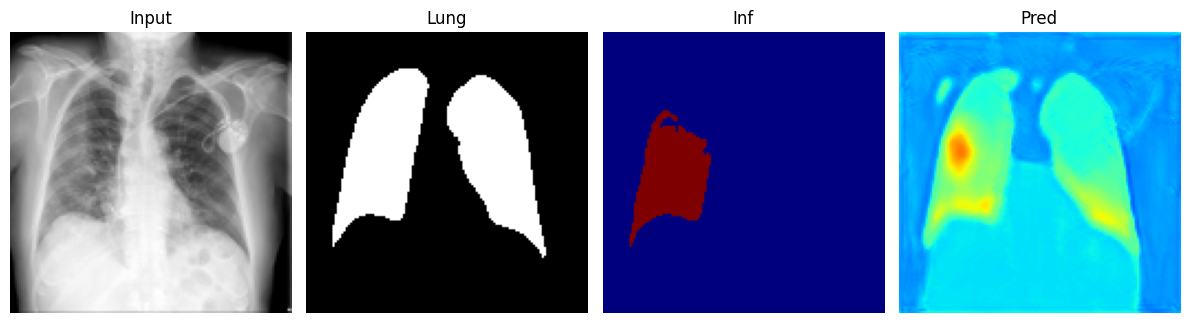

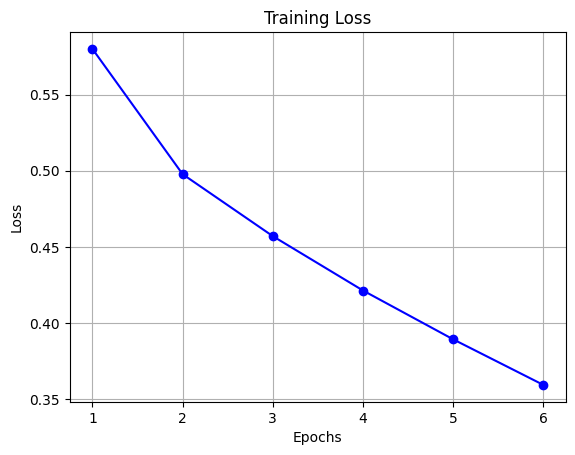

In [5]:
# 4. TRAINING LOOP
if __name__ == "__main__":
    if not os.path.exists(DATA_DIR): print("Path error"); exit()
    print("Loading Infection Dataset...")
    train_ds = InfectionDataset(DATA_DIR, 'Train')
    val_ds = InfectionDataset(DATA_DIR, 'Val')
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
    model = MiniUNet().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCELoss()
    print(f"Start Training on {DEVICE} with {len(train_ds)} images...")
    losses = []
    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            optimizer.zero_grad()
            preds = model(imgs)
            loss = criterion(preds, masks)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg = epoch_loss / len(train_loader)
        losses.append(avg)
        print(f"Epoch {epoch+1}/{EPOCHS} - Avg Loss: {avg:.4f}")

    # 5. VISUALIZATION
    model.eval()
    found = False
    for imgs, masks in val_loader:
        if masks[:, 1, :, :].max() > 0:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            with torch.no_grad(): preds = model(imgs)
            found = True; break
    if not found:
        imgs, masks = next(iter(val_loader))
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = model(imgs)
    idx = 0
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1); plt.imshow(imgs[idx].cpu().squeeze(), cmap='gray'); plt.title("Input"); plt.axis('off')
    plt.subplot(1, 4, 2); plt.imshow(masks[idx, 0].cpu(), cmap='bone'); plt.title("Lung"); plt.axis('off')
    plt.subplot(1, 4, 3); plt.imshow(masks[idx, 1].cpu(), cmap='jet', vmin=0, vmax=1); plt.title("Inf"); plt.axis('off')
    plt.subplot(1, 4, 4); plt.imshow(preds[idx, 1].cpu(), cmap='jet', vmin=0, vmax=1); plt.title("Pred"); plt.axis('off')
    plt.tight_layout(); plt.savefig('SEGMENTATION_RESULT.png')
    plt.figure()
    from matplotlib.ticker import MaxNLocator
    plt.plot(range(1, len(losses)+1), losses, 'b-o')
    plt.title("Training Loss")
    plt.xlabel("Epochs"); plt.ylabel("Loss")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True); plt.savefig('LOSS_CURVE.png')

In [6]:
# 6. QUANTITATIVE EVALUATION
def calculate_metrics(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    target = target.float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    dice = (2. * intersection) / (pred.sum() + target.sum() + 1e-6)
    iou = intersection / (union + 1e-6)
    return dice.item(), iou.item()
print("\nRunning Evaluation on Validation Set...")
model.eval()
dice_scores = []
iou_scores = []
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        preds = model(imgs)
        pred_infection = preds[:, 1, :, :]
        true_infection = masks[:, 1, :, :]
        for i in range(imgs.shape[0]):
            d, iou = calculate_metrics(pred_infection[i], true_infection[i])
            dice_scores.append(d)
            iou_scores.append(iou)
mean_dice = np.mean(dice_scores)
mean_iou = np.mean(iou_scores)
print("="*30)
print(f"FINAL RESULTS (Infection Class):")
print(f"Mean Dice Score: {mean_dice:.4f}")
print(f"Mean IoU Score : {mean_iou:.4f}")
print("="*30)
with open("evaluation_results.txt", "w") as f:
    f.write(f"Mean Dice Score: {mean_dice:.4f}\n")
    f.write(f"Mean IoU Score : {mean_iou:.4f}\n")


Running Evaluation on Validation Set...
FINAL RESULTS (Infection Class):
Mean Dice Score: 0.3202
Mean IoU Score : 0.2534
